<a href="https://colab.research.google.com/github/KorneliuszDyszczynski/ColorizingPhotosNeuralNetwork/blob/PlanA2/KolorajzerV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('theblackmamba31/landscape-image-colorization')

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
!unzip landscape-image-colorization.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: land

In [3]:
!mkdir /content/data
!mkdir /content/data/color

mkdir: cannot create directory ‘/content/data’: File exists
mkdir: cannot create directory ‘/content/data/color’: File exists


In [4]:
!mv landscape\ Images/color/* data/color

In [5]:
!rm -r results
!mkdir results
!mkdir test

mkdir: cannot create directory ‘test’: File exists


In [6]:
!mv landscape\ Images/gray/* test/

In [7]:
import keras
from keras.preprocessing import image
from keras.engine.topology import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
from time import time
import numpy as np
import os
import random
import tensorflow as tf
from PIL import Image, ImageFile
from IPython.display import Image, display

In [8]:
path = '//content/data/'
train_datagen = ImageDataGenerator(rescale=1. / 255)

In [9]:
vggmodel = VGG16()
newmodel = Sequential() 
num = 0
for i, layer in enumerate(vggmodel.layers):
    if i<19:
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [10]:
train = train_datagen.flow_from_directory(path, target_size=(224, 224),batch_size=2000,class_mode=None)

X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128)
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

Found 7129 images belonging to 1 classes.
(2000, 224, 224, 1)
(2000, 224, 224, 2)


In [11]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(2000, 7, 7, 512)


In [12]:
#Encoder
encoder_input = Input(shape=(7, 7, 512,))
#Decoder
decoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_input)
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)

In [13]:
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='//content/logs/')
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=1000, batch_size=50)

Epoch 1/1000
40/40 [==============================] - 12s 66ms/step - loss: 0.1217 - accuracy: 0.5054
Epoch 2/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0129 - accuracy: 0.5079
Epoch 3/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0121 - accuracy: 0.5435
Epoch 4/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0113 - accuracy: 0.6251
Epoch 5/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0104 - accuracy: 0.6789
Epoch 6/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0095 - accuracy: 0.6873
Epoch 7/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0087 - accuracy: 0.7028
Epoch 8/1000
40/40 [==============================] - 3s 66ms/step - loss: 0.0086 - accuracy: 0.7243
Epoch 9/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0082 - accuracy: 0.7153
Epoch 10/1000
40/40 [==============================] - 3s 65ms/step - loss: 0.0076 - accur

In [14]:
!rm -r //content/test/.ipynb_checkpoints

rm: cannot remove '//content/test/.ipynb_checkpoints': No such file or directory


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 95 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


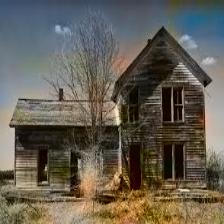

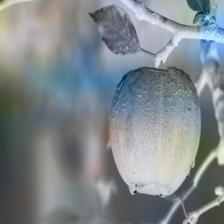

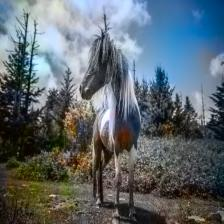

In [17]:
testpath = '//content/test/'
files = os.listdir(testpath)
for idx, file in enumerate(files):
    test = img_to_array(load_img(testpath+file))
    test = resize(test, (224,224), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    #print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    imsave('//content/results/'+str(idx)+".jpg", lab2rgb(cur))
    display(Image('//content/results/'+str(idx)+".jpg"))